In [379]:
import pandas as pd
import folium
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 200)

In [6]:
data = pd.read_csv('trip_en.csv')

/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (43,44,46,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
data

,TripID,UserID,PurposeID,Purpose,DepartureTime,ArrivalTime,TripTime,Validity,MainTransportationCode,MainTransportation,TransportationCode,Transportation,TransportationChange1_CD,TransportationChange1_name,TransportationChange1_time,TransportationChange2_CD,TransportationChange2_name,TransportationChange2_time,TransportationChange3_CD,TransportationChange3_name,TransportationChange3_time,TransportationChange4_CD,TransportationChange4_name,TransportationChange4_time,TransportationChange5_CD,TransportationChange5_name,TransportationChange5_time,TransportationChange6_CD,TransportationChange6_name,TransportationChange6_time,TransportationChange7_CD,TransportationChange7_name,TransportationChange7_time,TransportationChange8_CD,TransportationChange8_name,TransportationChange8_time,TransportationChange9_CD,TransportationChange9_name,TransportationChange9_time,TransportationChange10_CD,TransportationChange10_name,TransportationChange10_time,TransportationChange11_CD,TransportationChange11_name,TransportationChange11_time,TransportationChange12_CD,TransportationChange12_name,TransportationChange12_time,TransportationChange13_CD,TransportationChange13_name,TransportationChange13_time,TransportationChange14_CD,TransportationChange14_name,TransportationChange14_time,OD.Direct.Distance,LatO,LonO,shikucodeO,shikunameO,zone4codeO,zone4nameO,zone5codeO,zone5nameO,LatD,LonD,shikucodeD,shikunameD,zone4codeD,zone4nameD,zone5codeD,zone5nameD,age,sex.code,sex,Home.Position,Representative.Transportation.Code,Representative.Transportation,Selection.result.time,Whether.alternatives.can.be.generated.Car,Distancw.Car,Time.Car,Whether.alternatives.can.be.generated.Train,Distance.Train,Time.Train,Fare.Train,Departure.Station,Arrival.Station,Number.of.Change.Transportation.Train,Access.Distance.Train,Access.Time.Train,Egress.Distance.Train,Egress.time.Train,Total.Time.Train,Whether.alternatives.can.be.generated.Bike,Distance.Bike,Time.Bike,Whether.alternatives.can.be.generated.Walk,Distance.Walk,Time.Walk,Whether.alternatives.can.be.generated.Bus,Distance.Bus,Time.Bus,Fare.Bus,Access.Distance.Bus,Access.Time.Bus,Egress.Distance.Bus,Egress.Time.Bus,Total.Time.Bus
0,40509,4681,300,home,2018-08-27 17:27:17,2018-08-27 19:23:38,6981,1,100.0,train,101.0,subway,500.0,walk,2018-08-27 17:27:34,101.0,subway,2018-08-27 17:52:38,500.0,walk,2018-08-27 18:13:47,100.0,train,2018-08-27 18:17:05,500.0,NaN,2018-08-27 18:55:34,500.0,walk,2018-08-27 19:16:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29117.895608,139.780866,35.653891,1000607,NaN,NaN,NaN,NaN,NaN,139.998815,35.842997,1127914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,34.850,1.756411,1.0,36.738991,0.578553,697.242961,NaN,NaN,2.0,0.804839,0.167675,3.838000,0.799583,1.545811,NaN,NaN,NaN,1.0,33.172748,6.910989,1.0,40.04873,2.188455,1125.9221,0.916498,0.190937,45.218730,3.265539,5.644931
1,40515,4683,300,home,2018-08-27 18:14:20,2018-08-27 21:07:30,10390,1,101.0,subway,101.0,subway,500.0,walk,2018-08-27 18:52:52,999.0,--,2018-08-27 21:07:25,999.0,--,2018-08-27 21:07:29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.904654,139.797077,35.652133,1050376,NaN,NaN,NaN,NaN,NaN,139.796040,35.651433,1050369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.123,0.008605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.125057,0.026053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,40516,4687,300,home,2018-08-27 19:25:54,2018-08-27 21:10:00,6246,1,100.0,train,100.0,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2517.426917,139.780910,35.656450,1000394,NaN,NaN,NaN,NaN,NaN,139.759405,35.665614,1051500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.830,0.164259,1.0,2.125024,0.070834,141.875360,NaN,NaN,1.0,0.504970,0.105202,0.214000,0.04458

In [166]:
len(data)

12232

# 1. 緯度経度の準備

### y=mx+n

In [19]:
def makeLinearEquation(x1, y1, x2, y2):
    line = {}
    if y1 == y2:
        # y軸に平行な直線
        line["y"] = y1
    elif x1 == x2:
        # x軸に平行な直線
        line["x"] = x1
    else:
        # y = mx + n
        line["m"] = (y1 - y2) / (x1 - x2)
        line["n"] = y1 - (line["m"] * x1)
    return line

### Lat がx軸で　Lonがy軸です。

### ポイントを示す

In [215]:
pointA = (35.654994,139.764976)
pointB =(35.547032,139.835872)
pointC = (35.671242,139.846172)
pointD = (35.678145,139.789352)

In [220]:
fmap2 = folium.Map( 
    location=[pointA[0],pointA[1]], 
    zoom_start=11
)
folium.Marker([pointA[0],pointA[1]]).add_to(fmap2)
folium.Marker([pointB[0],pointB[1]]).add_to(fmap2)
folium.Marker([pointC[0],pointC[1]]).add_to(fmap2)
folium.Marker([pointD[0],pointD[1]]).add_to(fmap2)

fmap2

In [95]:
pointA = (35.654994,139.764976)
pointB =(35.547032,139.835872)
pointC = (35.671242,139.846172)
pointD = (35.678145,139.789352)

In [99]:
LineAB = makeLinearEquation(pointA[1],pointA[0], pointB[1],pointB[0])
LineBC = makeLinearEquation(pointB[1],pointB[0], pointC[1],pointC[0])
LineCD = makeLinearEquation(pointC[1],pointC[0], pointD[1],pointD[0])
LineDA = makeLinearEquation(pointD[1],pointD[0], pointA[1],pointA[0])


In [221]:
def under(Line, Lon, Lat):
    if Lon < Line['m'] * Lat + Line['n']:
        return True
    else:
        return False


In [222]:
def upper(Line,Lon,Lat):
    if Lon > Line['m'] * Lat + Line['n']:
        return True
    else:
        return False

# 2.a目的地が範囲のデータを取り出す

In [325]:
data = data.replace(np.NAN, '--')

In [326]:
lis_index = []
for i in range(len(data)):
    lis_index.append(upper(LineAB,data.LonD[i],data.LatD[i])& under(LineCD,data.LonD[i],data.LatD[i]) & upper(LineBC,data.LonD[i],data.LatD[i]) & under(LineDA,data.LonD[i],data.LatD[i]))

In [327]:
data_toToyosu = data[lis_index]

In [328]:
#new_data.to_csv('new_data.csv')

In [329]:
data_toToyosu = data_toToyosu.reset_index(drop=True)

In [330]:
data_toToyosu

,TripID,UserID,PurposeID,Purpose,DepartureTime,ArrivalTime,TripTime,Validity,MainTransportationCode,MainTransportation,TransportationCode,Transportation,TransportationChange1_CD,TransportationChange1_name,TransportationChange1_time,TransportationChange2_CD,TransportationChange2_name,TransportationChange2_time,TransportationChange3_CD,TransportationChange3_name,TransportationChange3_time,TransportationChange4_CD,TransportationChange4_name,TransportationChange4_time,TransportationChange5_CD,TransportationChange5_name,TransportationChange5_time,TransportationChange6_CD,TransportationChange6_name,TransportationChange6_time,TransportationChange7_CD,TransportationChange7_name,TransportationChange7_time,TransportationChange8_CD,TransportationChange8_name,TransportationChange8_time,TransportationChange9_CD,TransportationChange9_name,TransportationChange9_time,TransportationChange10_CD,TransportationChange10_name,TransportationChange10_time,TransportationChange11_CD,TransportationChange11_name,TransportationChange11_time,TransportationChange12_CD,TransportationChange12_name,TransportationChange12_time,TransportationChange13_CD,TransportationChange13_name,TransportationChange13_time,TransportationChange14_CD,TransportationChange14_name,TransportationChange14_time,OD.Direct.Distance,LatO,LonO,shikucodeO,shikunameO,zone4codeO,zone4nameO,zone5codeO,zone5nameO,LatD,LonD,shikucodeD,shikunameD,zone4codeD,zone4nameD,zone5codeD,zone5nameD,age,sex.code,sex,Home.Position,Representative.Transportation.Code,Representative.Transportation,Selection.result.time,Whether.alternatives.can.be.generated.Car,Distancw.Car,Time.Car,Whether.alternatives.can.be.generated.Train,Distance.Train,Time.Train,Fare.Train,Departure.Station,Arrival.Station,Number.of.Change.Transportation.Train,Access.Distance.Train,Access.Time.Train,Egress.Distance.Train,Egress.time.Train,Total.Time.Train,Whether.alternatives.can.be.generated.Bike,Distance.Bike,Time.Bike,Whether.alternatives.can.be.generated.Walk,Distance.Walk,Time.Walk,Whether.alternatives.can.be.generated.Bus,Distance.Bus,Time.Bus,Fare.Bus,Access.Distance.Bus,Access.Time.Bus,Egress.Distance.Bus,Egress.Time.Bus,Total.Time.Bus
0,40515,4683,300,home,2018-08-27 18:14:20,2018-08-27 21:07:30,10390,1,101,subway,101,subway,500,walk,2018-08-27 18:52:52,999,--,2018-08-27 21:07:25,999,--,2018-08-27 21:07:29,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,129.904654,139.797077,35.652133,1050376,--,--,--,--,--,139.796040,35.651433,1050369,--,--,--,--,--,--,--,--,--,--,--,--,1,0.123,0.00860537,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,1,0.125057,0.0260535,--,--,--,--,--,--,--,--,--
1,40519,4686,501,other,2018-08-27 16:36:20,2018-08-27 22:10:14,20034,1,201,bus,201,bus,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,7828.821734,139.726595,35.686786,67358,--,--,--,--,--,139.794115,35.661015,55198,--,--,--,--,--,--,--,--,--,--,--,--,1,8.229,0.419656,1,7.28493,0.242831,254.274,--,--,1,0.333,0.069375,0.783398,0.163208,0.475414,--,--,--,1,7.89395,1.64457,1,7.30075,0.398948,210,0.381,0.079375,8.71087,0.692723,1.17105
2,40526,4681,100,Work/School,2018-08-28 06:12:23,2018-08-28 07:38:48,5185,1,100,train,500,walk,201,bus,2018-08-28 06:15:43,100,train,2018-08-28 06:24:58,500,walk,2018-08-28 07:08:36,101,subway,2018-08-28 07:11:00,500,--,2018-08-28 07:30:14,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,28993.904245,139.998815,35.842997,1127914,--,--,--,--,--,139.780910,35.656450,1000394,--,--,--,--,--,--,--,--,--,--,--,--,1,34.759,1.75124,1,36.739,0.565319,697.243,--,--,2,3.394,0.707083,0.94897,0.197702,1.4701,--,--,--,1,32.811,6.83562,1,40.2403,2.19892,1125.92,0.26,0.0541667,45.6826,3.33275,5.58584
3,40558,4683,300,home,2018-08-28 19:32:16,2018-08-28 21:47:41,8125,1,101,subway,101,subway,500,walk,2018-08-28 19:40:25,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--

In [331]:
len(data_fromToyosu)

5299

# 2.b出発地が指定範囲のデータを取り出す

In [332]:
lis_index = []
for i in range(len(data)):
    lis_index.append(upper(LineAB,data.LonO[i],data.LatO[i])& under(LineCD,data.LonO[i],data.LatO[i]) & upper(LineBC,data.LonO[i],data.LatO[i]) & under(LineDA,data.LonO[i],data.LatO[i]))

In [333]:
data_fromToyosu = data[lis_index]

In [334]:
data_fromToyosu = data_fromToyosu.reset_index(drop=True)

In [348]:
data_toToyosu

,TripID,UserID,PurposeID,Purpose,DepartureTime,ArrivalTime,TripTime,Validity,MainTransportationCode,MainTransportation,TransportationCode,Transportation,TransportationChange1_CD,TransportationChange1_name,TransportationChange1_time,TransportationChange2_CD,TransportationChange2_name,TransportationChange2_time,TransportationChange3_CD,TransportationChange3_name,TransportationChange3_time,TransportationChange4_CD,TransportationChange4_name,TransportationChange4_time,TransportationChange5_CD,TransportationChange5_name,TransportationChange5_time,TransportationChange6_CD,TransportationChange6_name,TransportationChange6_time,TransportationChange7_CD,TransportationChange7_name,TransportationChange7_time,TransportationChange8_CD,TransportationChange8_name,TransportationChange8_time,TransportationChange9_CD,TransportationChange9_name,TransportationChange9_time,TransportationChange10_CD,TransportationChange10_name,TransportationChange10_time,TransportationChange11_CD,TransportationChange11_name,TransportationChange11_time,TransportationChange12_CD,TransportationChange12_name,TransportationChange12_time,TransportationChange13_CD,TransportationChange13_name,TransportationChange13_time,TransportationChange14_CD,TransportationChange14_name,TransportationChange14_time,OD.Direct.Distance,LatO,LonO,shikucodeO,shikunameO,zone4codeO,zone4nameO,zone5codeO,zone5nameO,LatD,LonD,shikucodeD,shikunameD,zone4codeD,zone4nameD,zone5codeD,zone5nameD,age,sex.code,sex,Home.Position,Representative.Transportation.Code,Representative.Transportation,Selection.result.time,Whether.alternatives.can.be.generated.Car,Distancw.Car,Time.Car,Whether.alternatives.can.be.generated.Train,Distance.Train,Time.Train,Fare.Train,Departure.Station,Arrival.Station,Number.of.Change.Transportation.Train,Access.Distance.Train,Access.Time.Train,Egress.Distance.Train,Egress.time.Train,Total.Time.Train,Whether.alternatives.can.be.generated.Bike,Distance.Bike,Time.Bike,Whether.alternatives.can.be.generated.Walk,Distance.Walk,Time.Walk,Whether.alternatives.can.be.generated.Bus,Distance.Bus,Time.Bus,Fare.Bus,Access.Distance.Bus,Access.Time.Bus,Egress.Distance.Bus,Egress.Time.Bus,Total.Time.Bus
0,40515,4683,300,home,2018-08-27 18:14:20,2018-08-27 21:07:30,10390,1,101,subway,101,subway,500,walk,2018-08-27 18:52:52,999,--,2018-08-27 21:07:25,999,--,2018-08-27 21:07:29,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,129.904654,139.797077,35.652133,1050376,--,--,--,--,--,139.796040,35.651433,1050369,--,--,--,--,--,--,--,--,--,--,--,--,1,0.123,0.00860537,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,1,0.125057,0.0260535,--,--,--,--,--,--,--,--,--
1,40519,4686,501,other,2018-08-27 16:36:20,2018-08-27 22:10:14,20034,1,201,bus,201,bus,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,7828.821734,139.726595,35.686786,67358,--,--,--,--,--,139.794115,35.661015,55198,--,--,--,--,--,--,--,--,--,--,--,--,1,8.229,0.419656,1,7.28493,0.242831,254.274,--,--,1,0.333,0.069375,0.783398,0.163208,0.475414,--,--,--,1,7.89395,1.64457,1,7.30075,0.398948,210,0.381,0.079375,8.71087,0.692723,1.17105
2,40526,4681,100,Work/School,2018-08-28 06:12:23,2018-08-28 07:38:48,5185,1,100,train,500,walk,201,bus,2018-08-28 06:15:43,100,train,2018-08-28 06:24:58,500,walk,2018-08-28 07:08:36,101,subway,2018-08-28 07:11:00,500,--,2018-08-28 07:30:14,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,28993.904245,139.998815,35.842997,1127914,--,--,--,--,--,139.780910,35.656450,1000394,--,--,--,--,--,--,--,--,--,--,--,--,1,34.759,1.75124,1,36.739,0.565319,697.243,--,--,2,3.394,0.707083,0.94897,0.197702,1.4701,--,--,--,1,32.811,6.83562,1,40.2403,2.19892,1125.92,0.26,0.0541667,45.6826,3.33275,5.58584
3,40558,4683,300,home,2018-08-28 19:32:16,2018-08-28 21:47:41,8125,1,101,subway,101,subway,500,walk,2018-08-28 19:40:25,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--

In [336]:
len(data_toToyosu)

5379

# 2.c指定範囲の内々トリップデータを取り出す

In [337]:
lis_index = []
for i in range(len(data)):
    lis_index.append(upper(LineAB,data.LonO[i],data.LatO[i])& under(LineCD,data.LonO[i],data.LatO[i]) & upper(LineBC,data.LonO[i],data.LatO[i]) & under(LineDA,data.LonO[i],data.LatO[i])&upper(LineAB,data.LonD[i],data.LatD[i])& under(LineCD,data.LonD[i],data.LatD[i]) & upper(LineBC,data.LonD[i],data.LatD[i]) & under(LineDA,data.LonD[i],data.LatD[i]))

In [338]:
data_fromToyosu_toToyosu = data[lis_index]

In [339]:
data_fromToyosu_toToyosu = data_fromToyosu_toToyosu.reset_index(drop=True)

In [340]:
data_fromToyosu_toToyosu

,TripID,UserID,PurposeID,Purpose,DepartureTime,ArrivalTime,TripTime,Validity,MainTransportationCode,MainTransportation,TransportationCode,Transportation,TransportationChange1_CD,TransportationChange1_name,TransportationChange1_time,TransportationChange2_CD,TransportationChange2_name,TransportationChange2_time,TransportationChange3_CD,TransportationChange3_name,TransportationChange3_time,TransportationChange4_CD,TransportationChange4_name,TransportationChange4_time,TransportationChange5_CD,TransportationChange5_name,TransportationChange5_time,TransportationChange6_CD,TransportationChange6_name,TransportationChange6_time,TransportationChange7_CD,TransportationChange7_name,TransportationChange7_time,TransportationChange8_CD,TransportationChange8_name,TransportationChange8_time,TransportationChange9_CD,TransportationChange9_name,TransportationChange9_time,TransportationChange10_CD,TransportationChange10_name,TransportationChange10_time,TransportationChange11_CD,TransportationChange11_name,TransportationChange11_time,TransportationChange12_CD,TransportationChange12_name,TransportationChange12_time,TransportationChange13_CD,TransportationChange13_name,TransportationChange13_time,TransportationChange14_CD,TransportationChange14_name,TransportationChange14_time,OD.Direct.Distance,LatO,LonO,shikucodeO,shikunameO,zone4codeO,zone4nameO,zone5codeO,zone5nameO,LatD,LonD,shikucodeD,shikunameD,zone4codeD,zone4nameD,zone5codeD,zone5nameD,age,sex.code,sex,Home.Position,Representative.Transportation.Code,Representative.Transportation,Selection.result.time,Whether.alternatives.can.be.generated.Car,Distancw.Car,Time.Car,Whether.alternatives.can.be.generated.Train,Distance.Train,Time.Train,Fare.Train,Departure.Station,Arrival.Station,Number.of.Change.Transportation.Train,Access.Distance.Train,Access.Time.Train,Egress.Distance.Train,Egress.time.Train,Total.Time.Train,Whether.alternatives.can.be.generated.Bike,Distance.Bike,Time.Bike,Whether.alternatives.can.be.generated.Walk,Distance.Walk,Time.Walk,Whether.alternatives.can.be.generated.Bus,Distance.Bus,Time.Bus,Fare.Bus,Access.Distance.Bus,Access.Time.Bus,Egress.Distance.Bus,Egress.Time.Bus,Total.Time.Bus
0,40515,4683,300,home,2018-08-27 18:14:20,2018-08-27 21:07:30,10390,1,101,subway,101,subway,500,walk,2018-08-27 18:52:52,999,--,2018-08-27 21:07:25,999,--,2018-08-27 21:07:29,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,129.904654,139.797077,35.652133,1050376,--,--,--,--,--,139.796040,35.651433,1050369,--,--,--,--,--,--,--,--,--,--,--,--,1,0.123,0.00860537,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,1,0.125057,0.0260535,--,--,--,--,--,--,--,--,--
1,40558,4683,300,home,2018-08-28 19:32:16,2018-08-28 21:47:41,8125,1,101,subway,101,subway,500,walk,2018-08-28 19:40:25,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,244.019574,139.796180,35.654610,1000470,--,--,--,--,--,139.797040,35.651970,1000710,--,--,--,--,--,--,--,--,--,--,--,--,1,0.411,0.0246403,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,1,0.375513,0.0782318,--,--,--,--,--,--,--,--,--
2,40580,4683,200,Working,2018-08-29 15:25:59,2018-08-29 19:13:30,13651,1,100,train,100,train,500,walk,2018-08-29 19:05:25,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,27.229722,139.797030,35.652290,1000712,--,--,--,--,--,139.797040,35.651970,1000710,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,1,0.0455261,0.0094846,--,--,--,--,--,--,--,--,--
3,40582,4700,300,home,2018-08-29 18:12:03,2018-08-29 19:42:50,5447,1,300,car,600,airplane,300,car,2018-09-03 12:19:35,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,1417.218466,139.797577,35.663723,1050606,--,--,--,--,--,139.793268,35.648038,1001327,--,--,--,--,--,--,--,--,--,--,--,--,1,2.481,0.150036,--,--,--,--,--,--,--,

In [341]:
len(data_fromToyosu_toToyosu)

3404

In [257]:
#data_fromToyosu_toToyosu.to_csv('data_fromToyosu_toToyosu.csv')

# 3.トリップチェーン分析

## 3.a 目的地が範囲のデータ

In [369]:
def TripChain(df):
    Lis = []
    lis = []
    for i in range(len(df)):
        for colum in colums:
            lis.append(df.iloc[i][colum])
        Lis.append(lis)
        lis =[]
        
    TripChain = pd.DataFrame(Lis).fillna('--')
    display(len(TripChain))
    display(len(TripChain.drop_duplicates()))
    return pd.DataFrame(TripChain.groupby(TripChain.columns.tolist(),as_index=False).size())

In [356]:
a = TripChain(data_toToyosu)

5379

319

In [358]:
#a.to_csv('data_toToyosu.csv')

In [418]:
TripChain_toToyosu = pd.read_csv('data_toToyosu.csv')

In [419]:
TripChain_toToyosu

,0,1,2,3,4,5,TripChain,Value
0,walk,--,--,--,--,--,"walk,--,--,--,--,--",1477
1,bike,--,--,--,--,--,"bike,--,--,--,--,--",452
2,walk,subway,walk,--,--,--,"walk,subway,walk,--,--,--",432
3,car,--,--,--,--,--,"car,--,--,--,--,--",290
4,subway,--,--,--,--,--,"subway,--,--,--,--,--",223
...,...,...,...,...,...,...,...,...
314,walk,train,walk,taxi,walk,--,"walk,train,walk,taxi,walk,--",1
315,walk,train,walk,train,--,--,"walk,train,walk,train,--,--",1
316,walk,walk,subway,train,walk,--,"walk,walk,subway,train,walk,--",1
317,walk,walk,subway,walk,subway,--,"walk,walk,subway,walk,subway,--",1


##### 上位nパターンを図示

In [422]:
def plot_TripChain(df, n, use_walk):
    sns.set()
    if use_walk:
        x = np.array(df['TripChain'][:n])
        y = np.array(df['Value'][:n])
    else:
        x = np.array(df['TripChain'][1:n])
        y = np.array(df['Value'][1:n])

    x_position = np.arange(len(x))

    fig = plt.figure()
    plt.xticks(rotation=45)
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(x_position, y, tick_label=x)
    ax.set_xlabel('TripChain')
    ax.set_ylabel('frequency')
    fig.show()

/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


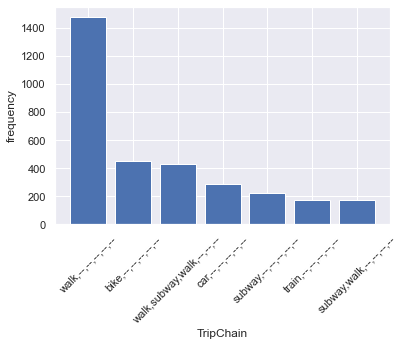

In [423]:
plot_TripChain(TripChain_toToyosu, n = 7, use_walk=True)

/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


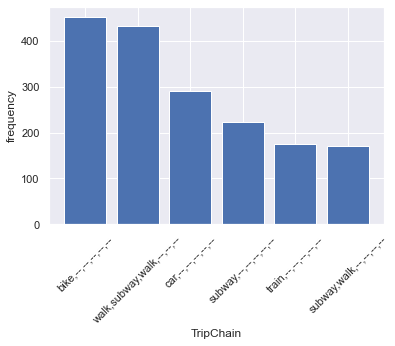

In [424]:
plot_TripChain(TripChain_toToyosu, n= 7, use_walk=False)

##### walkを除く

## 3.b 出発地が範囲のデータ

In [402]:
a = TripChain(data_fromToyosu)

5299

311

In [403]:
#a.to_csv('data_fromToyosu.csv')

In [404]:
TripChain_fromToyosu = pd.read_csv('data_fromToyosu.csv')

In [405]:
TripChain_fromToyosu

,0,1,2,3,4,5,TripChain,Value
0,walk,--,--,--,--,--,"walk,--,--,--,--,--",1481
1,walk,subway,walk,--,--,--,"walk,subway,walk,--,--,--",462
2,bike,--,--,--,--,--,"bike,--,--,--,--,--",442
3,car,--,--,--,--,--,"car,--,--,--,--,--",265
4,subway,--,--,--,--,--,"subway,--,--,--,--,--",216
...,...,...,...,...,...,...,...,...
306,walk,tram,--,--,--,--,"walk,tram,--,--,--,--",1
307,walk,tram,walk,bus,--,--,"walk,tram,walk,bus,--,--",1
308,walk,walk,bus,walk,walk,--,"walk,walk,bus,walk,walk,--",1
309,walk,walk,subway,walk,--,--,"walk,walk,subway,walk,--,--",1


##### 上位nパターンを図示

/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


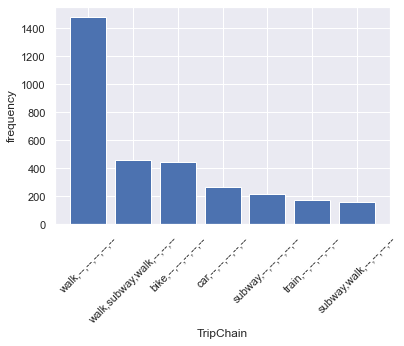

In [425]:
plot_TripChain(TripChain_fromToyosu, n = 7, use_walk=True)

/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


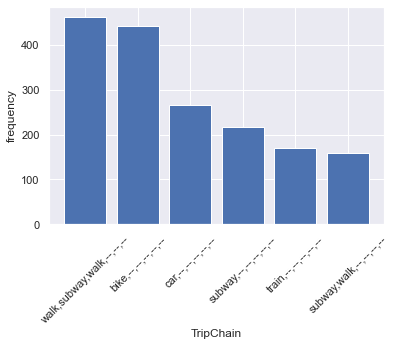

In [426]:
plot_TripChain(TripChain_fromToyosu, n = 7, use_walk=False)

## 3.c 指定範囲の内々トリップデータ

In [375]:
a = TripChain(data_fromToyosu_toToyosu)

3404

227

In [376]:
#a.to_csv('data_fromToyosu_toToyosu.csv')

In [377]:
TripChain_fromToyosu_toToyosu = pd.read_csv('data_fromToyosu_toToyosu.csv')

In [378]:
TripChain_fromToyosu_toToyosu

,0,1,2,3,4,5,TripChain,Value
0,walk,--,--,--,--,--,"walk,--,--,--,--,--",1141
1,bike,--,--,--,--,--,"bike,--,--,--,--,--",329
2,walk,subway,walk,--,--,--,"walk,subway,walk,--,--,--",247
3,car,--,--,--,--,--,"car,--,--,--,--,--",174
4,subway,--,--,--,--,--,"subway,--,--,--,--,--",155
...,...,...,...,...,...,...,...,...
222,walk,train,walk,subway,--,--,"walk,train,walk,subway,--,--",1
223,walk,train,walk,taxi,--,--,"walk,train,walk,taxi,--,--",1
224,walk,train,walk,train,--,--,"walk,train,walk,train,--,--",1
225,walk,train,walk,train,walk,--,"walk,train,walk,train,walk,--",1


##### 上位nパターンを図示

/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


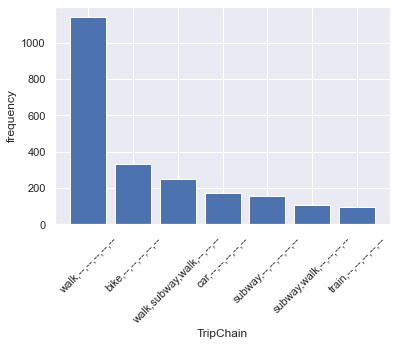

In [427]:
plot_TripChain(TripChain_fromToyosu_toToyosu, n = 7, use_walk= True)

/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


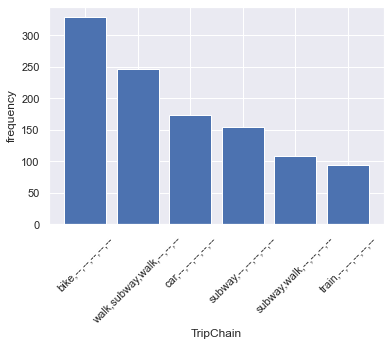

In [428]:
plot_TripChain(TripChain_fromToyosu_toToyosu, n = 7, use_walk= False)

# 4. ModeChain

In [434]:
def ModeChain(df1):
    user_list = df1["UserID"].unique()
    user_list =  np.sort(user_list)
    list_daytime = []
    for index, row in df1.iterrows():
        list_daytime.append(datetime.datetime.strptime(row["DepartureTime"], '%Y-%m-%d %H:%M:%S'))
    df1["daytime"] = list_daytime
    day = datetime.datetime(2018,8,27)# 初日
    day_index_list = []
    while True:
        day_index_list.append(day.strftime('%Y-%m-%d'))
        if day == datetime.datetime(2018,12,31): break#最後の日まで
        day += datetime.timedelta(days=1)

    df4 = pd.DataFrame([],index=day_index_list)#空
    # display(df4)

    for user in user_list:
        df2 = df1[df1["UserID"]==user]
        atcivity_list = []
        day = datetime.datetime(2018,8,27)
        while True:
            df3 = df2[(df2["daytime"] >= day)&(df2["daytime"] <= day+datetime.timedelta(days=1))]#その日を取り出す
            atcivity_list.append("->".join(list(df3["Purpose"])))
            if day == datetime.datetime(2018,12,31): break
            day += datetime.timedelta(days=1) 
        df4[user] = atcivity_list
    df5 = pd.Series( df4.values.reshape([-1]) )#短冊切って一列に
    act_pat_df = df5.value_counts()
    act_pat_df.index.name="activity_pattern"
    act_pat_df = act_pat_df.reset_index()
    act_pat_df["index"] = range(len(act_pat_df))
    act_pat_df = act_pat_df.set_index("index")
    act_pat_df = act_pat_df.rename(columns={0: 'num'})#名前をつけただけ
    return act_pat_df.drop(0)

## 4.a　目的地が範囲のデータ

In [436]:
ModeChain_toToyosu = ModeChain(data_toToyosu)

In [440]:
ModeChain_toToyosu

,activity_pattern,num
index,,
1,Work/School,1240
2,home,602
3,Work/School->home,260
4,Shopping->home,111
5,Working,94
...,...,...
345,Working->Work/School->Work/School->Shopping->W...,1
346,Work/School->Shopping->Working-> Eating,1
347,Lesson->home->other->Shopping,1


In [438]:
def plot_TripChain(df, n):
    sns.set()

    x = np.array(df['activity_pattern'][:n])
    y = np.array(df['num'][:n])

    x_position = np.arange(len(x))

    fig = plt.figure()
    plt.xticks(rotation=45)
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(x_position, y, tick_label=x)
    ax.set_xlabel('activity_pattern')
    ax.set_ylabel('frequency')
    fig.show()

/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


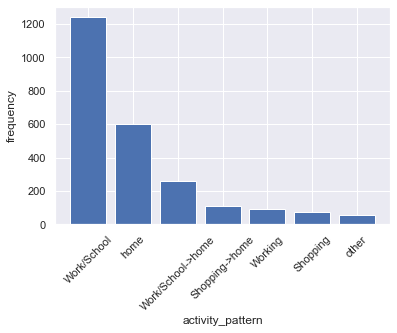

In [439]:
plot_TripChain(ModeChain_toToyosu,n = 7)

## 4. b 出発地が範囲のデータ

In [441]:
ModeChain_fromToyosu = ModeChain(data_fromToyosu)

In [442]:
ModeChain_fromToyosu

,activity_pattern,num
index,,
1,home,835
2,Work/School,523
3,Work/School->home,329
4,Shopping,128
5,Working,127
...,...,...
370,Pickup->Shopping->Pickup->home,1
371,Pickup->Hospital->other->home->Lesson->home,1
372,Hospital-> Eating->home->Hospital->Shopping,1


/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


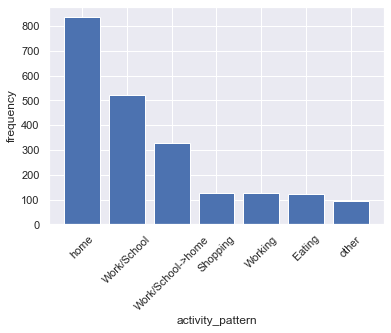

In [443]:
plot_TripChain(ModeChain_fromToyosu,n = 7)

## 4. c 内々トリップ

In [444]:
ModeChain_fromToyosu_toToyosu = ModeChain(data_fromToyosu_toToyosu)

In [445]:
ModeChain_fromToyosu_toToyosu

,activity_pattern,num
index,,
1,home,334
2,Work/School,296
3,Work/School->home,194
4,Working,88
5,Shopping->home,88
...,...,...
304,Work/School->Working-> Eating,1
305,Sightseeing->Shopping,1
306,Hospital->home->other->home,1


/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/Users/tabatashunya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


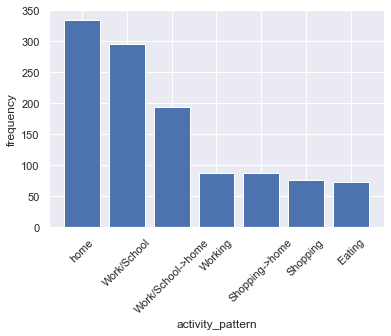

In [446]:
plot_TripChain(ModeChain_fromToyosu_toToyosu,n = 7)